In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import csv
import string
from textblob import TextBlob as blob
from scipy import stats
from pymongo import MongoClient
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import sentiment as vaderSentiment 

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import TweetTokenizer


# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
import lda
from sklearn.decomposition import PCA, LatentDirichletAllocation

# visualization
import pyLDAvis

%matplotlib inline

/Users/nickryan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
nltk.download('punkt')

True

In [3]:
from pymongo import MongoClient

client = MongoClient()
db = client.test

# pull tweets out of mongo
def out_of_mongo(collection):
    tweet_list = []
    for tweet in collection.find():
        tweet_list.append(tweet)
    return tweet_list

In [596]:
# trump data
dt_data = out_of_mongo(db.trumptweets)

In [597]:
len(dt_data)

600

In [598]:
# convert to pandas df
def data_to_df(data):
    # variables explained: https://dev.twitter.com/overview/api/tweets
    df = pd.DataFrame(data)
    df.drop_duplicates(subset = 'id', inplace = True)
    keep = ['id', 'created_at', 'text', 
            'favorite_count', 'retweet_count',  
            'is_quote_status', 'quoted_status', 'quoted_status_id', 
            'in_reply_to_screen_name', 'in_reply_to_status_id', 'retweeted_status', 
            'entities', 'source']
    df = df[keep]
    return df

dt = data_to_df(dt_data)

In [599]:
dt.describe()

,id,favorite_count,retweet_count,quoted_status_id
count,6.000000e+02,600.000000,600.000000,1.300000e+01
mean,7.274467e+17,17548.981667,6353.610000,7.146530e+17
std,3.636266e+16,14577.500224,5191.303563,3.672723e+16
min,6.751208e+17,0.000000,434.000000,6.743172e+17
25%,6.771484e+17,4702.500000,2115.250000,NaN
50%,7.462896e+17,14627.000000,5197.000000,NaN
75%,7.583705e+17,26317.750000,8902.750000,NaN
max,7.622845e+17,83230.000000,31203.000000,7.612773e+17


In [8]:
dt.shape

(600, 13)

In [600]:
def is_retweet(retweeted_status):
    """Check if tweet is retweet."""
    try:
        if np.isnan(retweeted_status) == True:
            return 
    except:
        return 1
    
def get_week(date):
    """Return start of week (Monday) given a date."""
    week = date - timedelta(days = date.weekday())
    return week

def add_metadata(df):
    """Add date, is retweet, month, and week features to df."""
    # add date as datetime object
    df.loc[:, 'date'] = df.loc[:, 'created_at'].apply(lambda x: pd.to_datetime(x).date())
    
    # add if retweet
    df.loc[:, 'is_retweet'] = df.loc[:, 'retweeted_status'].apply(is_retweet)
    
    # add week
    df.loc[:, 'week'] = df.loc[:, 'date'].apply(get_week)
    
    # add month
    df.loc[:, 'month'] = df.loc[:, 'date'].apply(lambda x: x.replace(day = 1))

In [601]:
add_metadata(dt)

In [11]:
def plot_feats(df, featurelist): 
    """Plot features of dataframe
    Args:
    df (dataframe) -- dataframe
    featurelist (list) -- list of features to plot
    """    
    plt.figure(figsize = (20, 8))
    plt.title('Retweets and Favorites', fontsize = 14)
    for feature in featurelist:
        plt.plot(df[feature])
    plt.legend(loc = 'best')
    plt.show()

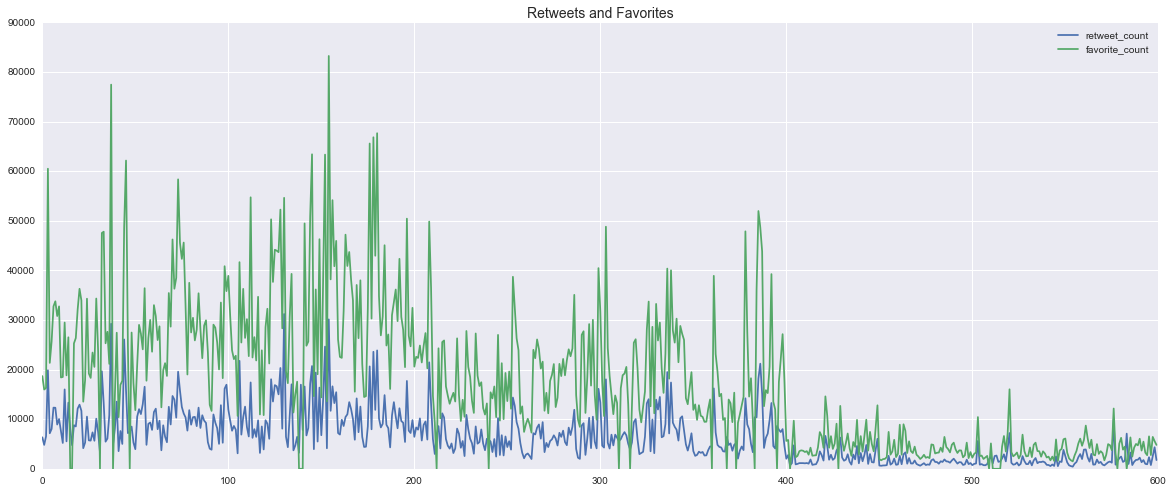

In [12]:
# compare retweets vs. favorites

plot_feats(dt, ['retweet_count', 'favorite_count'])

In [602]:
# group by date

groupby_date_fav = dt['favorite_count'].groupby(dt['date'])
groupby_date_rt = dt['retweet_count'].groupby(dt['date'])

In [603]:
meanfav_df = groupby_date_fav.mean()
meanrt_df = groupby_date_rt.mean()
meanfav_df.head()
meanrt_df.head()

date
2015-12-11    2086.714286
2015-12-12    2097.086957
2015-12-13    1273.342857
2015-12-14    2229.315789
2015-12-15    1302.037037
Name: retweet_count, dtype: float64

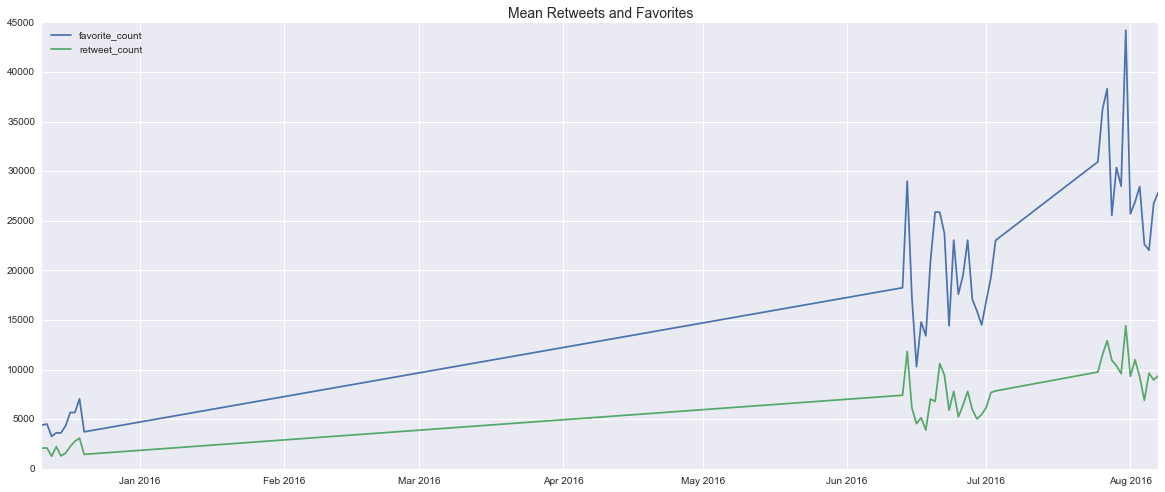

In [15]:
# favorites and retweets reduced variance (by date)

def plot_compare(dfs): 
    plt.figure(figsize = (20, 8))
    plt.title('Mean Retweets and Favorites', fontsize = 14)
    for df in dfs:
        plt.plot(df)
    plt.legend(loc = 'best')
    plt.show()
    
plot_compare([meanfav_df, meanrt_df])

In [604]:
# Tokenize tweets, with a number of options:
#
# word_tokenizer from nltk
# TweetTokenizer from nltk
# Custom tokenizer from https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [605]:
dt.loc[:, 'sentences'] = dt.loc[:, 'text'].apply(sent_tokenize)
dt.loc[:, 'tokens']    = dt.loc[:, 'text'].apply(preprocess)

In [606]:
dt.head()

,id,created_at,text,favorite_count,retweet_count,is_quote_status,quoted_status,quoted_status_id,in_reply_to_screen_name,in_reply_to_status_id,retweeted_status,entities,source,date,is_retweet,week,month,sentences,tokens
0,762284533341417472,Sun Aug 07 13:49:29 +0000 2016,I see where Mayor Stephanie Rawlings-Blake of ...,18689,6343,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht...","<a href=""http://twitter.com/download/android"" ...",2016-08-07,NaN,2016-08-01,2016-08-01,[I see where Mayor Stephanie Rawlings-Blake of...,"[I, see, where, Mayor, Stephanie, Rawlings-Bla..."
1,762110918721310721,Sun Aug 07 02:19:37 +0000 2016,"Thank you Windham, New Hampshire! #TrumpPence1...",15984,4818,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht...","<a href=""http://twitter.com/download/iphone"" r...",2016-08-07,NaN,2016-08-01,2016-08-01,"[Thank you Windham, New Hampshire!, #TrumpPenc...","[Thank, you, Windham, ,, New, Hampshire, !, #T..."
2,762106904436961280,Sun Aug 07 02:03:39 +0000 2016,.@Larry_Kudlow - 'Donald Trump Is the middle-c...,16312,6547,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [{u'indices...","<a href=""http://twitter.com/download/iphone"" r...",2016-08-07,NaN,2016-08-01,2016-08-01,"[., @Larry_Kudlow - 'Donald Trump Is the middl...","[., @Larry_Kudlow, -, ', Donald, Trump, Is, th..."
3,762104411707568128,Sun Aug 07 01:53:45 +0000 2016,I am not just running against Crooked Hillary ...,60500,19862,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht...","<a href=""http://twitter.com/download/android"" ...",2016-08-07,NaN,2016-08-01,2016-08-01,[I am not just running against Crooked Hillary...,"[I, am, not, just, running, against, Crooked, ..."
4,762016426102296576,Sat Aug 06 20:04:08 +0000 2016,#CrookedHillary is not fit to be our next pres...,21357,7160,False,NaN,NaN,None,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht...","<a href=""http://twitter.com/download/iphone"" r...",2016-08-06,NaN,2016-08-01,2016-08-01,[#CrookedHillary is not fit to be our next pre...,"[#CrookedHillary, is, not, fit, to, be, our, n..."


In [628]:
dt['source'].value_counts()

Android                                                                              276
iPhone                                                                               272
Web                                                                                   49
<a href="http://instagram.com" rel="nofollow">Instagram</a>                            2
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>      1
Name: source, dtype: int64

In [629]:
keys = {'<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>': 'Android', 
        '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'iPhone', 
        '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Web'}
dt = dt.replace({"source": keys})

In [29]:
# import emotion lexicon
emotion_lexicon = pd.read_csv('NRC_Emotion_Lexicon.csv', header=0)
emotion_lexicon[1:20]

,English Word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,1,0,0,0,1,0,1,0,0
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0
5,abate,0,0,0,0,0,0,0,0,0,0
6,abatement,0,0,0,0,0,0,0,0,0,0
7,abba,1,0,0,0,0,0,0,0,0,0
8,abbot,0,0,0,0,0,0,0,0,0,1
9,abbreviate,0,0,0,0,0,0,0,0,0,0
10,abbreviation,0,0,0,0,0,0,0,0,0,0


In [607]:
affects = ['Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust',
           'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']

# create emotion dictionary
emotion_words = dict()
for key in affects:
    emotion_words[key] = emotion_lexicon[(emotion_lexicon[key] == 1)]['English Word'].tolist()

In [608]:
# counts number of words in tweet matching values in emotion dictionary for a given emotion
def emotioncount(df, emotion):
    col = []
    for line in df:
        emotcount = 0
        for word in line:
            if word in emotion_words[emotion]:
                emotcount = emotcount + 1
        col.append(emotcount)
    return col

In [609]:
dt.loc[:, 'number of tokens'] = dt['tokens'].apply(len)

for affect in affects:
    dt.loc[:, affect] = emotioncount(dt['tokens'], affect)
    dt.loc[:, affect + " ratio"] = dt[affect] / dt['number of tokens']
    
dt.head()

,id,created_at,text,favorite_count,retweet_count,is_quote_status,quoted_status,quoted_status_id,in_reply_to_screen_name,in_reply_to_status_id,...,Fear,Fear ratio,Joy,Joy ratio,Sadness,Sadness ratio,Surprise,Surprise ratio,Trust,Trust ratio
0,762284533341417472,Sun Aug 07 13:49:29 +0000 2016,I see where Mayor Stephanie Rawlings-Blake of ...,18689,6343,False,NaN,NaN,None,None,...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.000000
1,762110918721310721,Sun Aug 07 02:19:37 +0000 2016,"Thank you Windham, New Hampshire! #TrumpPence1...",15984,4818,False,NaN,NaN,None,None,...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.000000
2,762106904436961280,Sun Aug 07 02:03:39 +0000 2016,.@Larry_Kudlow - 'Donald Trump Is the middle-c...,16312,6547,False,NaN,NaN,None,None,...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.000000
3,762104411707568128,Sun Aug 07 01:53:45 +0000 2016,I am not just running against Crooked Hillary ...,60500,19862,False,NaN,NaN,None,None,...,0,0.0,0,0.0,1,0.037037,0,0.0,0,0.000000
4,762016426102296576,Sat Aug 06 20:04:08 +0000 2016,#CrookedHillary is not fit to be our next pres...,21357,7160,False,NaN,NaN,None,None,...,0,0.0,0,0.0,0,0.000000,0,0.0,1,0.083333


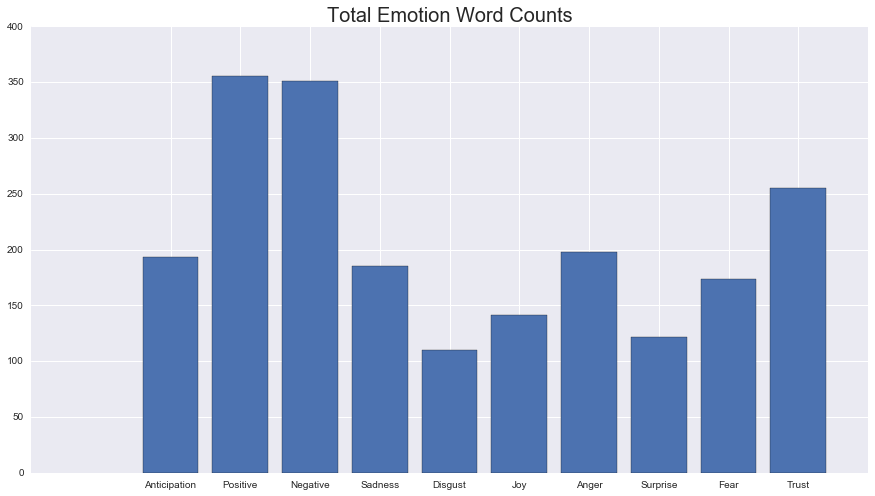

In [645]:
emotion_sums = dict()
for key in affects:
    emotion_sums[key] = sum(dt[key])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts', fontsize = 20)
plt.bar(range(len(emotion_sums)), emotion_sums.values(), align='center', )
plt.xticks(range(len(emotion_sums)), emotion_sums.keys())

plt.show()

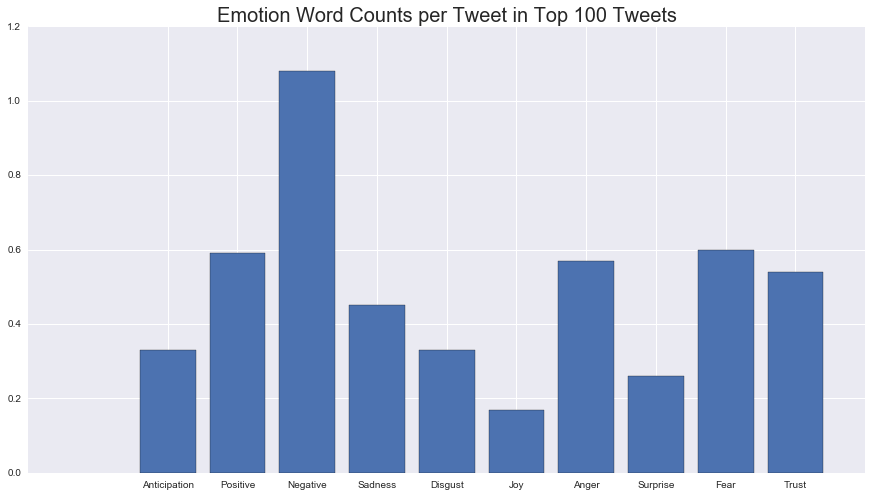

In [754]:
by_favorite = dt.sort(['favorite_count'], ascending = False)

emotion_sums = dict()
for key in affects:
    emotion_sums[key] = sum(by_favorite[key][:100]) / 100.0

plt.figure(figsize=(15,8))
plt.title('Emotion Word Counts per Tweet in Top 100 Tweets', fontsize = 20)
plt.bar(range(len(emotion_sums)), emotion_sums.values(), align='center', )
plt.xticks(range(len(emotion_sums)), emotion_sums.keys())

plt.show()

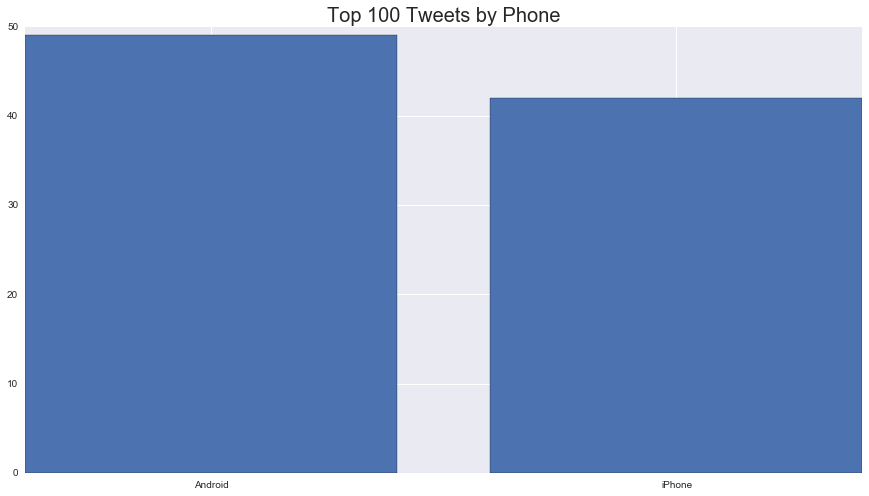

In [752]:
phones = ['Android', 'iPhone']
top_100_by_phone = dict()
for key in phones:
    top_100_by_phone[key] = len(by_favorite['source'][:100][by_favorite['source'] == key])
    
plt.figure(figsize=(15,8))
plt.title('Top 100 Tweets by Phone', fontsize = 20)
plt.bar(range(len(top_100_by_phone)), top_100_by_phone.values(), align='center', )
plt.xticks(range(len(top_100_by_phone)), top_100_by_phone.keys())

plt.show()

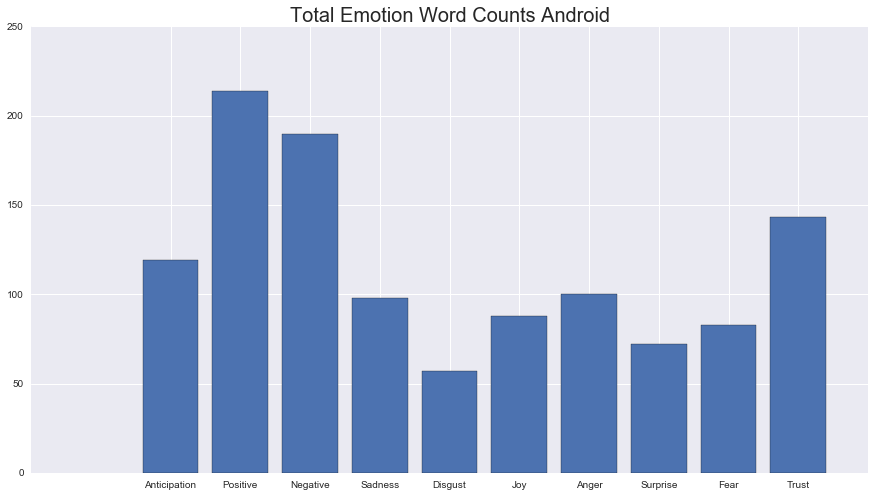

In [649]:
emotion_sums_android = dict()
for key in affects:
    emotion_sums_android[key] = sum(dt[key][dt['source']=='Android'])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts Android', fontsize = 20)
plt.bar(range(len(emotion_sums_android)), emotion_sums_android.values(), align='center', )
plt.xticks(range(len(emotion_sums_android)), emotion_sums_android.keys())

plt.show()

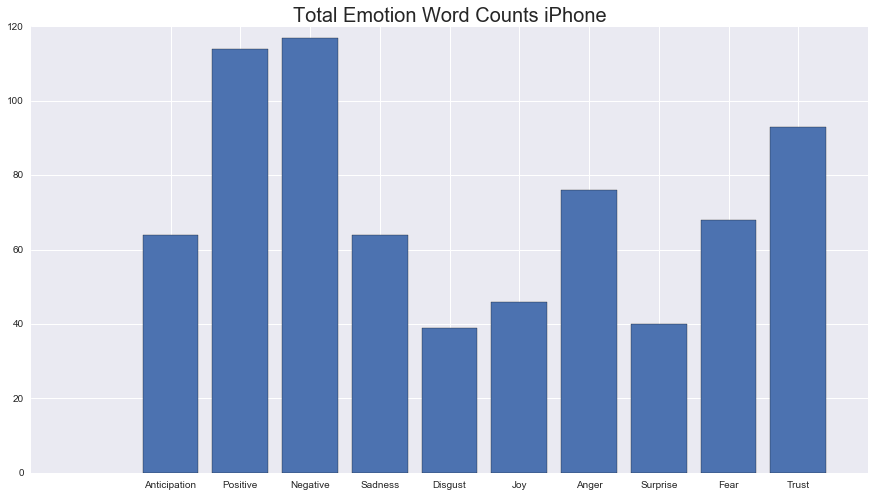

In [650]:
emotion_sums_iphone = dict()
for key in affects:
    emotion_sums_iphone[key] = sum(dt[key][dt['source']=='iPhone'])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts iPhone', fontsize = 20)
plt.bar(range(len(emotion_sums_iphone)), emotion_sums_iphone.values(), align='center', )
plt.xticks(range(len(emotion_sums_iphone)), emotion_sums_iphone.keys())

plt.show()

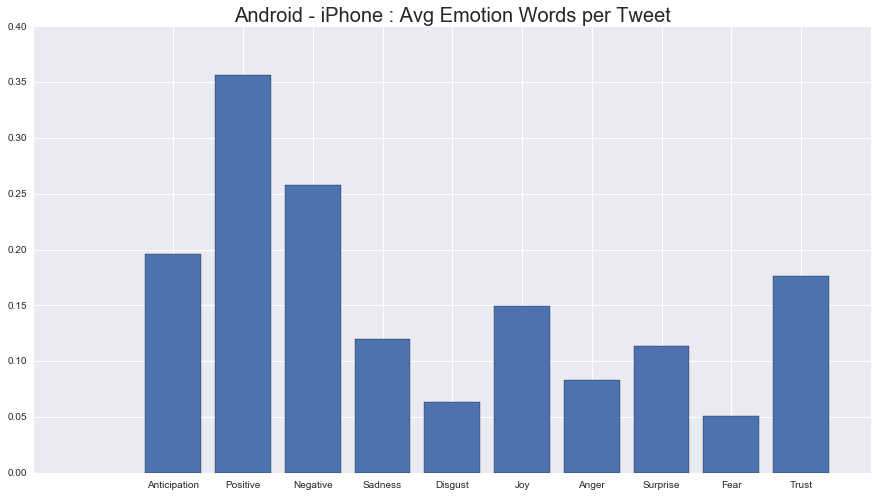

In [749]:
# almost same number of iPhone/Android tweets, Android tweets contain more emotion words on average in all categories

emotion_avg_iphone = {key: (emotion_sums_iphone[key] / float(len(dt[dt['source']=='iPhone'])))  for key in emotion_sums_iphone.keys()}
emotion_avg_android = {key: (emotion_sums_android[key] / float(len(dt[dt['source']=='Android'])))  for key in emotion_sums_android.keys()}

emotions_diff = {key: emotion_avg_android[key] - emotion_avg_iphone.get(key, 0) for key in emotion_avg_android.keys()}

plt.figure(figsize=(15,8))
plt.title('Android - iPhone : Avg Emotion Words per Tweet', fontsize = 20)
plt.bar(range(len(emotions_diff)), emotions_diff.values(), align='center', )
plt.xticks(range(len(emotions_diff)), emotions_diff.keys())

plt.show()

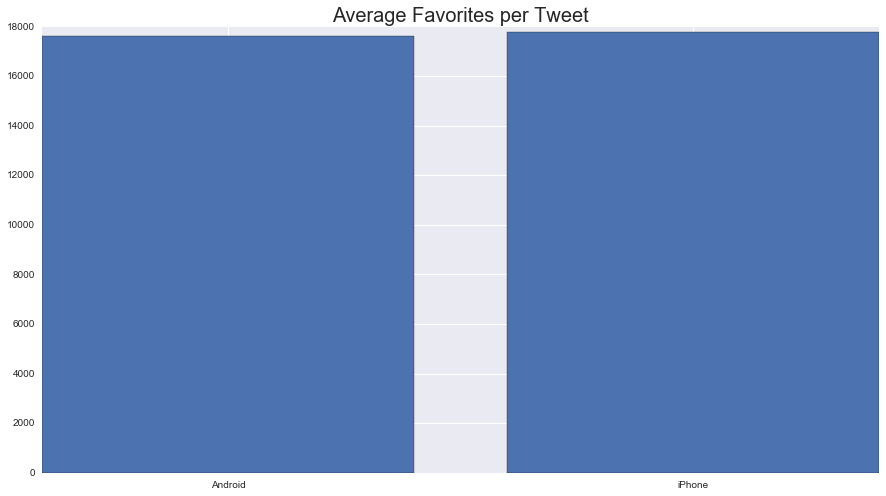

In [672]:
phones = ['Android', 'iPhone']
favorite_by_phone = dict()
for key in phones:
    favorite_by_phone[key] = sum(dt['favorite_count'][dt['source'] == key]) / len(dt[dt['source'] == key])

plt.figure(figsize=(15,8))
plt.title('Average Favorites per Tweet', fontsize = 20)
plt.bar(range(len(favorite_by_phone)), favorite_by_phone.values(), align='center', )
plt.xticks(range(len(favorite_by_phone)), favorite_by_phone.keys())

plt.show()

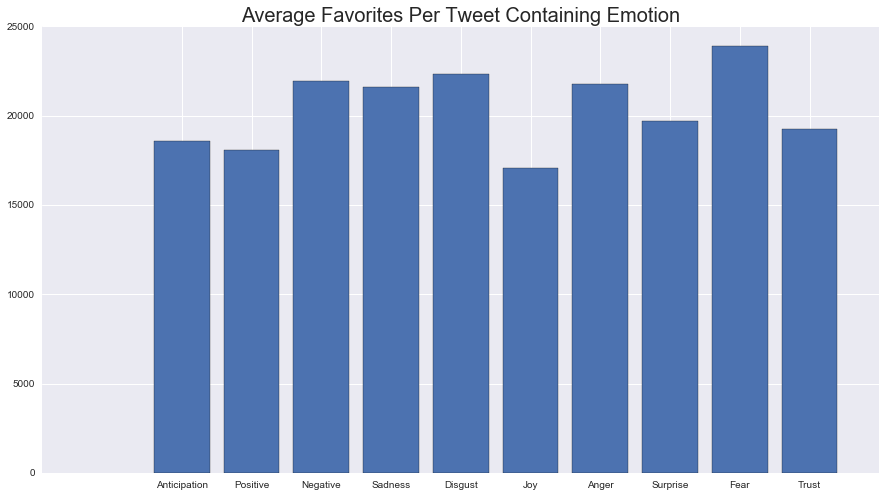

In [669]:
favorite_emotions = dict()
for key in affects:
    favorite_emotions[key] = sum(dt['favorite_count'][dt[key] > 0]) / len(dt[dt[key] > 0])

plt.figure(figsize=(15,8))
plt.title('Average Favorites Per Tweet Containing Emotion', fontsize = 20)
plt.bar(range(len(favorite_emotions)), favorite_emotions.values(), align='center', )
plt.xticks(range(len(favorite_emotions)), favorite_emotions.keys())

plt.show()

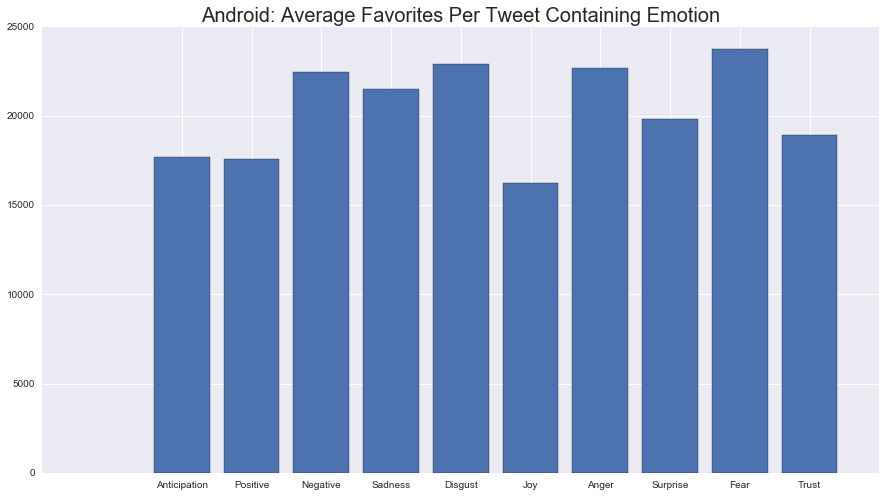

In [709]:
android_favorite_emotions = dict()
for key in affects:
    android_favorite_emotions[key] = sum(dt['favorite_count'][dt[key] > 0][dt['source'] == 'Android']) / len(dt[dt[key] > 0][dt['source'] == 'Android'])

plt.figure(figsize=(15,8))
plt.title('Android: Average Favorites Per Tweet Containing Emotion', fontsize = 20)
plt.bar(range(len(android_favorite_emotions)), android_favorite_emotions.values(), align='center', )
plt.xticks(range(len(android_favorite_emotions)), android_favorite_emotions.keys())

plt.show()

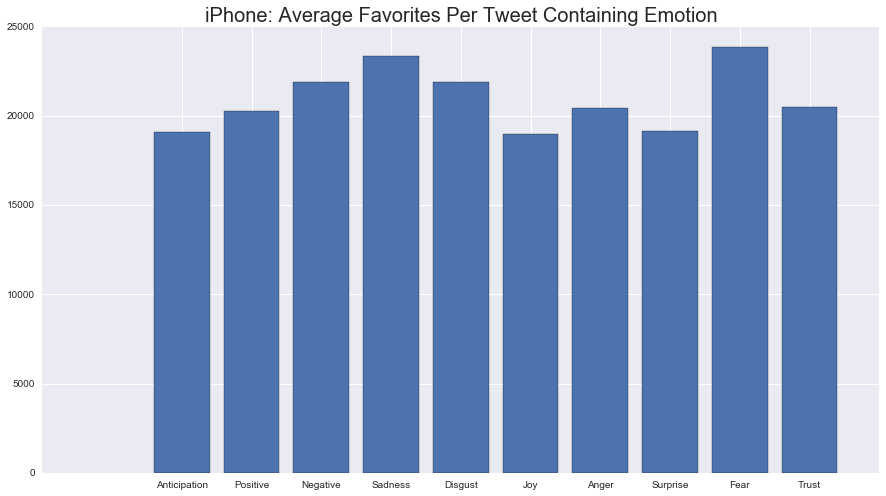

In [684]:
iphone_favorite_emotions = dict()
for key in affects:
    iphone_favorite_emotions[key] = sum(dt['favorite_count'][dt[key] > 0][dt['source'] == 'iPhone']) / len(dt[dt[key] > 0][dt['source'] == 'iPhone'])

plt.figure(figsize=(15,8))
plt.title('iPhone: Average Favorites Per Tweet Containing Emotion', fontsize = 20)
plt.bar(range(len(iphone_favorite_emotions)), iphone_favorite_emotions.values(), align='center', )
plt.xticks(range(len(iphone_favorite_emotions)), iphone_favorite_emotions.keys())

plt.show()

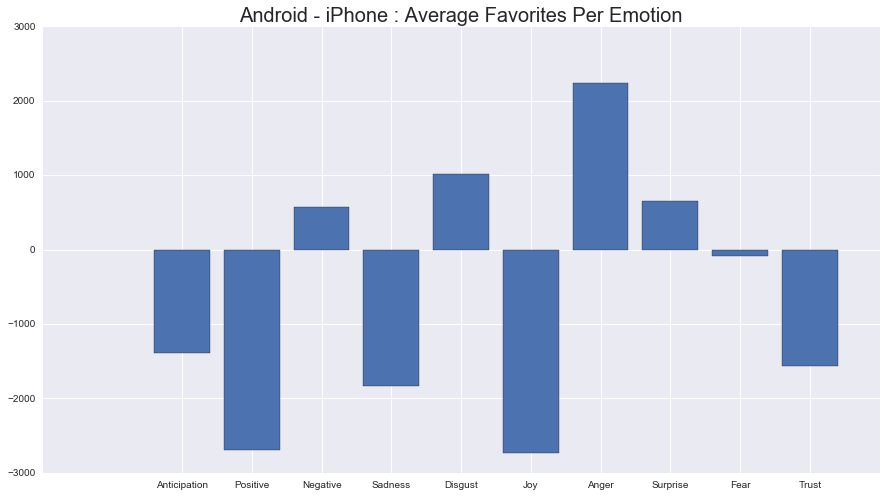

In [694]:
fav_emotions_diff = {key: android_favorite_emotions[key] - iphone_favorite_emotions.get(key, 0) for key in android_favorite_emotions.keys()}

plt.figure(figsize=(15,8))
plt.title('Android - iPhone : Average Favorites Per Emotion', fontsize = 20)
plt.bar(range(len(fav_emotions_diff)), fav_emotions_diff.values(), align='center', )
plt.xticks(range(len(fav_emotions_diff)), fav_emotions_diff.keys())

plt.show()

Insights:
- Android tweets are more emotional
- Among the top favorited tweets, negativity and fear dominate
- Tweets with fear and disgust get more favorites overall
- More top tweets come from Android
- Overall, Android and iPhone have similar distribution of emotions
- Despite having similar proportions of emtions, Android tweets conveying negativity, disgust, anger, and surprise garner  significantly more favorites, and iPhone tweets conveying anticipation, positivity, sadness, joy, and trust garner significantly more favorites
- Android is better at garnering favorites from negative sentiments, iPhone is better at garnering favorites from positive sentiments; each one is attracting a different kind of audience

In [586]:
mini = pd.DataFrame([[['abhor', 'abide', 'abhorrent', 'abhor', 'abeyance', 'abolish', 'abuse', 'abuse']],
              [['aberration','aberrant','abduction']],
              [['abdominal','abdomen','abbreviation']],
              [['sfsadf','asdfasf','asdfjsf']],
              [['abhor', 'abolish', 'abhor']]])

mini.columns = ['words']

In [595]:
def anger_count(df):
    angerval = 0
    for words in mini['words']:
        for word in words:
            if word in emotion_words['Negative']:
                angerval = angerval + 1
        return angerval

def anger_count2(df):
    for words in mini['words']:
        angerval = 0
        for word in words:
            if word in emotion_words['Negative']:
                angerval = angerval + 1
        return angerval
    
def anger_exist(df):
    for words in mini['words']:
        for word in words:
            if word in emotion_words['Negative']:
                return 1
    
    
myvar = 'whatever'    
mini.loc[:, myvar + ' k'] = mini['words'].apply(anger_count3)
#mini.loc[:, 'angercount4'] = mini.apply(anger_count)


#mini.loc[:, 'angercount4'] = anger_exist(mini.loc[:, 'words'])
#mini.loc[:, 'angercount4'] = anger_count(mini.loc[:, 'words'])
#mini['plz'] = mini.apply(anger_exist, axis=1)

mini.loc[:, myvar + ' count'] = mini['words'].apply(len)

mini

,words,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,whatever k,whatever count
0,"[abhor, abide, abhorrent, abhor, abeyance, abo...",0,6,6,0,5,5,0,2,0,0,None,8
1,"[aberration, aberrant, abduction]",0,3,0,0,1,1,0,1,1,0,None,3
2,"[abdominal, abdomen, abbreviation]",0,0,0,0,0,0,0,0,0,0,None,3
3,"[sfsadf, asdfasf, asdfjsf]",0,0,0,0,0,0,0,0,0,0,None,3
4,"[abhor, abolish, abhor]",0,3,3,0,2,2,0,0,0,0,None,3


In [31]:
nltk.download('stopwords')

True

In [33]:
from nltk.corpus import stopwords 
import string
    
stop_words = set(stopwords.words('english'))
stop_words.update([s for s in string.punctuation] +
                       [u'\u2014', u'\u2019', u'\u201c', u'\xf3', u'\u201d', u'\u2014@', u'://', u'!"', u'"@',
                        u'."', u'.@', u'co', u'\u2026', u'&', u'&amp', u'amp', u'...', u'.\u201d', u'000',
                        u'\xed'])
stop_words.update(['realdonaldtrump', 'hillaryclinton', 'berniesanders'])

In [ ]:
emotion_words = dict()
emotion_words['positive'] = data[(data['affect'] == 'positive') & (data['flag'] == 1)]['word'].tolist()

In [ ]:
from nltk.tokenize import wordpunct_tokenize
from collections import Counter

emotion_words = dict()
emotion_map = dict()
affects = ['Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust',
           'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
for key in affects:
    emotion_words[key] = emotion_lexicon[(emotion_lexicon[key] == 1)]['English Word'].tolist()
    emotion_map[key] = list()
    
#emotion_lexicon

for text in dt['tokens']:  # Note no stemming or it may fail to match words
    words = Counter([i.lower() for i in wordpunct_tokenize(text)
                 if i.lower() not in stop_words and not i.lower().startswith('http')])
    for key in emotion_words.keys():
        x = set(emotion_words[key]).intersection(words.keys())
        emotion_map[key].append(len(x))
sentiment = pd.DataFrame(emotion_map)

In [70]:
from collections import Counter

def get_sentiment(self):
    # Load up the NRC emotion lexicon

    data = pd.read_csv('NRC_Emotion_Lexicon.csv', delim_whitespace=True, skiprows=45, header=None, names=['word', 'affect', 'flag'])

    emotion_words = dict()
    emotion_map = dict()
    affects = ['positive', 'negative', 'anger', 'anticipation', 'disgust',
               'fear', 'joy', 'sadness', 'surprise', 'trust']
    for key in affects:
        emotion_words[key] = data[(data['affect'] == key) & (data['flag'] == 1)]['word'].tolist()
        emotion_map[key] = list()

    for text in self.data:  # Note no stemming or it may fail to match words
        words = Counter([i.lower() for i in wordpunct_tokenize(text)
                     if i.lower() not in self.stop_words and not i.lower().startswith('http')])
        for key in emotion_words.keys():
            x = set(emotion_words[key]).intersection(words.keys())
            emotion_map[key].append(len(x))
    self.sentiment = pd.DataFrame(emotion_map)

In [71]:
get_sentiment(mini)

TypeError: invalid type comparison

In [ ]:
def count_disgust(text):
    disgust = 0
    for i in text:
        for word in emotion_lexicon['English Word']:
            if i == word && 
    
    

def add_emotions(df):
    # add disgust
    %time df.loc[:, 'disgust'] = df.loc[:, 'words'].apply(get_sentences)
    
    # add fear
    %time df.loc[:, 'fear'] = df.loc[:, 'words'].apply(get_tokens)
   

In [17]:
# stop words, stemming, etc. cleaning.

In [21]:
def get_sentences(text):
    """Return list of sentences in tweet."""
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

In [48]:
def get_polarity(sents):
    """Return polarity score for each sentence in text."""
    return [sentiment(x)[0] for x in sents]

def get_vader_sentiment(text):
    """Return vaderSentiment score for text."""
    try:
        return vaderSentiment(text)['compound']
    except:
        return 0
    
def get_subjectivity(sents):
    """Return subjectivity score for each sentence in text."""
    return [sentiment(x)[1] for x in sents]

def get_is_fact(sents):
    """Return modality score for each sentence in text."""
    return [modality(x) for x in sents]

def get_mood(sents):
    """Return modality score for each sentence in text."""
    return [mood(x) for x in sents]

def get_mood_mode(mood):
    """Return most commonly occuring modality score for each tweet."""
    try:
        return stats.mode(mood)[0][0]
    except:
        return mood

In [49]:
# get hashtags and mentions
def get_hashtags(entities):
    """Return a list of all hashtags used in tweet."""
    try:
        return [entities['hashtags'][i]['text'] for i in range(len(entities['hashtags']))]
    except:
        return 

def get_user_mentions(entities):
    """Return a list of all user mentions in tweet."""
    try:
        return [entities['user_mentions'][i]['screen_name'] for i in range(len(entities['user_mentions']))]
    except:
        return
    
def get_first_hashtag(entities):
    """Return first hashtag used in tweet."""
    try:
        return [entities['hashtags'][i]['text'] for i in range(len(entities['hashtags']))][0]
    except:
        return 

def get_first_user_mentions(entities):
    """Return first user mentioned in tweet."""
    try:
        return [entities['user_mentions'][i]['screen_name'] for i in range(len(entities['user_mentions']))][0]
    except:
        return

def has_media(entities):
    """Return type of media if tweet contains media, blank if not."""
    try:
        return entities['media'][0]['type']
    except:
        return

In [50]:
def get_tokens(text):  
    """Return lemmatized tokens for each review."""
    text = re.sub(r"http\S+", "hyperlink", text) # replace urls with str hyperlink
    letters_only = re.sub("[^a-zA-Z0-9@]", " ", text) # remove everything except numbers, hashtags, and @
    words = ' '.join(letters_only.lower().split())
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    return ' '.join(filtered)

In [51]:
def get_features(df):
    # add sentences
    %time df.loc[:, 'sentences'] = df.loc[:, 'text'].apply(get_sentences)
    
    # add tokens
    %time df.loc[:, 'tokens'] = df.loc[:, 'text'].apply(get_tokens)
    
    # add sentiment, subjectivity, modality, and mood scores by sentence
    %time df.loc[:, 'sentiment'] = df.loc[:, 'sentences'].apply(get_polarity)
    %time df.loc[:, 'mood'] = df.loc[:, 'sentences'].apply(get_mood)
    %time df.loc[:, 'modality'] = df.loc[:, 'sentences'].apply(get_is_fact)
    %time df.loc[:, 'subjectivity'] = df.loc[:, 'sentences'].apply(get_subjectivity)
    %time df.loc[:, 'vader_sentiment'] = df.loc[:, 'text'].apply(get_vader_sentiment)

    
    # average the above scores
    %time df.loc[:, 'avg_sentiment'] = df.loc[:, 'sentiment'].apply(np.mean)
    %time df.loc[:, 'mode_mood'] = df.loc[:, 'mood'].apply(get_mood_mode)
    %time df.loc[:, 'avg_modality'] = df.loc[:, 'modality'].apply(np.mean)
    %time df.loc[:, 'avg_subjectivity'] = df.loc[:, 'subjectivity'].apply(np.mean)
    
    # count number of tokens
    df.loc[:, 'num_tokens'] = df.loc[:, 'tokens'].apply(lambda x: len(x.split()))
    
    # count number of characters
    df.loc[:, 'num_chars'] = df.loc[:, 'tokens'].apply(lambda x: len(x))
    
    # add user mentions, hashtags, and media
    df.loc[:, 'hashtags'] = df.loc[:, 'entities'].apply(get_hashtags)
    df.loc[:, 'user_mentions'] = df.loc[:, 'entities'].apply(get_user_mentions)
    df.loc[:, 'media'] = df.loc[:, 'entities'].apply(has_media)
    
    # count number of hyperlinks
    df.loc[:, 'num_hyperlinks'] = df.loc[:, 'tokens'].apply(lambda x: x.split().count('hyperlink'))
    
    # return first hashtag
    df.loc[:, 'first_hashtag'] = df.loc[:, 'entities'].apply(get_first_hashtag)
    
    # return first user mention
    df.loc[:, 'first_user_mention'] = df.loc[:, 'entities'].apply(get_first_user_mentions)

    return df

In [52]:
# load spacy, stopwords, and punctuation
nlp = spacy.en.English()
stop = STOPWORDS
punct = {p for p in string.punctuation if p != '@' and p != '#'}

In [ ]:
get_features(dt)

In [54]:
dt.head()

,id,created_at,text,favorite_count,retweet_count,is_quote_status,quoted_status,quoted_status_id,in_reply_to_screen_name,in_reply_to_status_id,...,avg_modality,avg_subjectivity,num_tokens,num_chars,hashtags,user_mentions,media,num_hyperlinks,first_hashtag,first_user_mention
0,762284533341417472,Sun Aug 07 13:49:29 +0000 2016,I see where Mayor Stephanie Rawlings-Blake of ...,18689,6343,False,NaN,NaN,None,None,...,0.833333,0.106944,26,131,[],[],None,0,None,None
1,762110918721310721,Sun Aug 07 02:19:37 +0000 2016,"Thank you Windham, New Hampshire! #TrumpPence1...",15984,4818,False,NaN,NaN,None,None,...,1.000000,0.227273,8,59,"[TrumpPence16, MAGA]",[],photo,1,TrumpPence16,None
2,762106904436961280,Sun Aug 07 02:03:39 +0000 2016,.@Larry_Kudlow - 'Donald Trump Is the middle-c...,16312,6547,False,NaN,NaN,None,None,...,0.750000,0.000000,11,73,[],[larry_kudlow],None,1,None,larry_kudlow
3,762104411707568128,Sun Aug 07 01:53:45 +0000 2016,I am not just running against Crooked Hillary ...,60500,19862,False,NaN,NaN,None,None,...,0.750000,0.475000,24,126,[],[],None,0,None,None
4,762016426102296576,Sat Aug 06 20:04:08 +0000 2016,#CrookedHillary is not fit to be our next pres...,21357,7160,False,NaN,NaN,None,None,...,0.750000,0.100000,11,73,"[CrookedHillary, TrumpPence16]",[],None,1,CrookedHillary,None
